<a href="https://colab.research.google.com/github/zhouning64/Test-fork/blob/master/LGMM2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages if not already installed
!pip install yfinance pandas numpy scikit-learn matplotlib -q

[*********************100%***********************]  1 of 1 completed
Generating signals: 100%|██████████| 3111/3111 [00:01<00:00, 2015.13it/s]


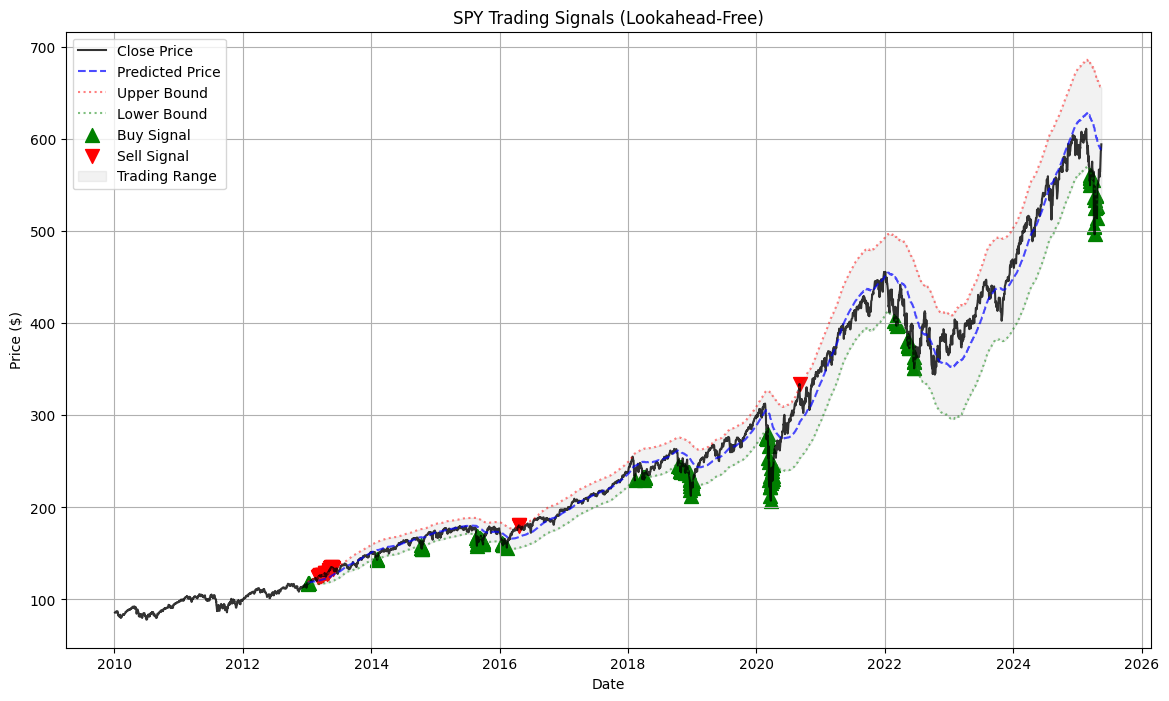


=== Transaction Log ===


,Date,Type,Price,Shares,Value,Commission,Cash,Position
0,2013-01-07,BUY,117.552376,85.0,9991.951942,5,3.048058,long
1,2013-03-05,SELL,124.252617,85.0,10561.472435,5,10559.520493,out
2,2014-02-03,BUY,143.094757,73.0,10445.917267,5,108.603226,long
3,2016-04-18,SELL,179.805923,73.0,13125.832413,5,13229.435638,out
4,2018-02-08,BUY,229.356537,57.0,13073.322601,5,151.113037,long
5,2020-09-02,SELL,334.045624,57.0,19040.600555,5,19186.713593,out
6,2022-02-23,BUY,402.606598,47.0,18922.510101,5,259.203491,long



=== Strategy Performance ===
Initial Capital: $10,000.00
Final Portfolio Value: $28,186.60
Total Return: 181.87%
Buy & Hold Return: 592.80%
Number of Trades: 7
Win Rate: 100.00%
Average Trade Return: 25.67%
Max Drawdown: -33.43%


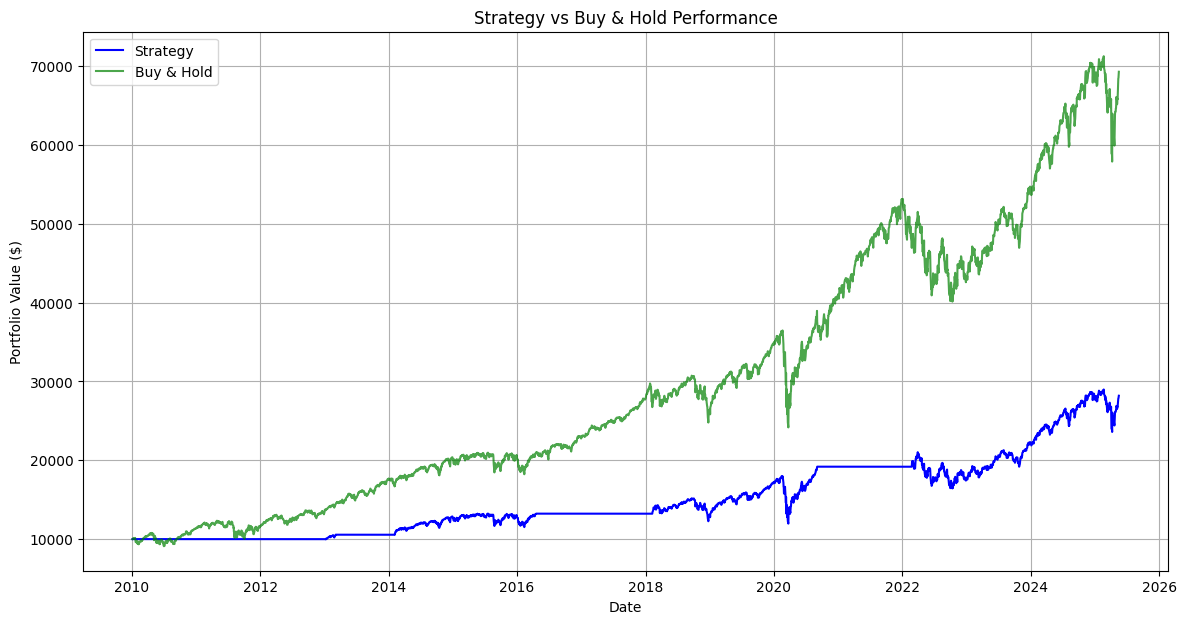

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from IPython.display import display
from tqdm import tqdm

def get_clean_financial_data(ticker, start_date, end_date):
    """Download and clean financial data from Yahoo Finance"""
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data.columns = data.columns.get_level_values(0)
    data = data.ffill()  # Forward fill missing values
    data.index = data.index.tz_localize(None)  # Remove timezone
    return data

def prepare_data(data):
    """Prepare data for modeling"""
    data = data.reset_index()
    data['Date_Ordinal'] = pd.to_numeric(data['Date'].map(pd.Timestamp.toordinal))
    X = data[['Date_Ordinal']].values
    y = data['Close'].values
    return X, y, data

def train_models_rolling(X, y, n_components=3, degree=2, train_window=252):
    """Train models using rolling window approach to avoid lookahead bias"""
    y_pred = np.full_like(y, np.nan)

    for i in tqdm(range(train_window, len(X)), desc="Training models"):
        X_train = X[i-train_window:i]
        y_train = y[i-train_window:i]

        # Train GMM
        gmm = GaussianMixture(n_components=n_components,
                             covariance_type='full',
                             random_state=42)
        gmm.fit(X_train)
        latent_features = gmm.predict_proba(X_train)
        X_latent = np.hstack([X_train, latent_features])

        # Train Poly Regression
        poly_reg = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
        )
        poly_reg.fit(X_latent, )

        # Predict current value (no future data)
        current_latent = gmm.predict_proba(X[i].reshape(1, -1))
        current_X_latent = np.hstack([X[i].reshape(1, -1), current_latent])
        y_pred[i] = poly_reg.predict(current_X_latent)[0]

    return y_pred

def generate_signals_rolling(data, y_pred, window=252, std_multiplier=2):
    """Generate signals using rolling window to avoid lookahead bias"""
    residuals = data['Close'] - y_pred
    data['Upper_Bound'] = np.nan
    data['Lower_Bound'] = np.nan

    for i in tqdm(range(window, len(data)), desc="Generating signals"):
        # Calculate std dev using only lookback window
        current_std = np.std(residuals.iloc[i-window:i])

        # Set bounds for current period only
        data.loc[data.index[i], 'Upper_Bound'] = y_pred[i] + std_multiplier * current_std
        data.loc[data.index[i], 'Lower_Bound'] = y_pred[i] - std_multiplier * current_std

    # Generate signals
    data['Buy_Signal'] = np.where(data['Close'] < data['Lower_Bound'], 1, 0)
    data['Sell_Signal'] = np.where(data['Close'] > data['Upper_Bound'], 1, 0)

    return data

def plot_trading_signals(data, ticker):
    """Plot the trading signals with price and bounds"""
    plt.figure(figsize=(14, 8))

    # Plot closing price
    plt.plot(data['Date'], data['Close'], label='Close Price', color='black', alpha=0.8, linewidth=1.5)

    # Plot predicted values
    plt.plot(data['Date'], data['Predicted'], label='Predicted Price', color='blue', alpha=0.7, linestyle='--')

    # Plot bounds
    plt.plot(data['Date'], data['Upper_Bound'], label='Upper Bound', color='red', alpha=0.5, linestyle=':')
    plt.plot(data['Date'], data['Lower_Bound'], label='Lower Bound', color='green', alpha=0.5, linestyle=':')

    # Plot signals
    buy_signals = data[data['Buy_Signal'] == 1]
    sell_signals = data[data['Sell_Signal'] == 1]

    plt.scatter(buy_signals['Date'], buy_signals['Close'],
                label='Buy Signal', color='green', marker='^', s=100, alpha=1)
    plt.scatter(sell_signals['Date'], sell_signals['Close'],
                label='Sell Signal', color='red', marker='v', s=100, alpha=1)

    # Fill between bounds
    plt.fill_between(data['Date'], data['Lower_Bound'], data['Upper_Bound'],
                     color='gray', alpha=0.1, label='Trading Range')

    plt.title(f'{ticker} Trading Signals (Lookahead-Free)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def backtest_strategy(data, initial_capital=10000, commission=5):
    """Backtest the trading strategy with transaction log"""
    cash = initial_capital
    shares = 0
    portfolio_value = []
    transactions = []
    position = 'out'

    for i, row in data.iterrows():
        current_date = row['Date']
        current_price = row['Close']

        buy_signal = row['Buy_Signal']
        sell_signal = row['Sell_Signal']

        if position == 'out' and buy_signal:
            shares_to_buy = cash // current_price
            if shares_to_buy > 0:
                cost = shares_to_buy * current_price + commission
                cash -= cost
                shares += shares_to_buy
                position = 'long'

                transactions.append({
                    'Date': current_date,
                    'Type': 'BUY',
                    'Price': current_price,
                    'Shares': shares_to_buy,
                    'Value': shares_to_buy * current_price,
                    'Commission': commission,
                    'Cash': cash,
                    'Position': position
                })

        elif position == 'long' and sell_signal:
            if shares > 0:
                proceeds = shares * current_price - commission
                cash += proceeds

                transactions.append({
                    'Date': current_date,
                    'Type': 'SELL',
                    'Price': current_price,
                    'Shares': shares,
                    'Value': shares * current_price,
                    'Commission': commission,
                    'Cash': cash,
                    'Position': 'out'
                })

                shares = 0
                position = 'out'

        current_value = cash + shares * current_price
        portfolio_value.append(current_value)

    portfolio_df = pd.DataFrame({
        'Date': data['Date'],
        'Portfolio_Value': portfolio_value,
        'Stock_Price': data['Close']
    })

    transactions_df = pd.DataFrame(transactions)
    return portfolio_df, transactions_df

def calculate_performance_metrics(portfolio_df, transactions_df, initial_capital):
    """Calculate and display key performance metrics"""
    final_value = portfolio_df['Portfolio_Value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_and_hold_return = (portfolio_df['Stock_Price'].iloc[-1] - portfolio_df['Stock_Price'].iloc[0]) / portfolio_df['Stock_Price'].iloc[0] * 100

    num_trades = len(transactions_df)
    num_winning_trades = 0
    trade_returns = []

    for i in range(0, num_trades-1, 2):
        if i+1 < num_trades:
            buy_price = transactions_df.iloc[i]['Price']
            sell_price = transactions_df.iloc[i+1]['Price']
            trade_return = (sell_price - buy_price) / buy_price * 100
            trade_returns.append(trade_return)
            if trade_return > 0:
                num_winning_trades += 1

    win_rate = num_winning_trades / len(trade_returns) * 100 if len(trade_returns) > 0 else 0
    avg_trade_return = np.mean(trade_returns) if len(trade_returns) > 0 else 0

    portfolio_df['Peak'] = portfolio_df['Portfolio_Value'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['Portfolio_Value'] - portfolio_df['Peak']) / portfolio_df['Peak']
    max_drawdown = portfolio_df['Drawdown'].min() * 100

    print("\n=== Strategy Performance ===")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Buy & Hold Return: {buy_and_hold_return:.2f}%")
    print(f"Number of Trades: {num_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Average Trade Return: {avg_trade_return:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")

def main():
    # Configuration
    ticker = 'SPY'
    start_date = '2010-01-01'
    end_date = '2025-05-17'
    initial_capital = 10000
    commission = 5
    n_components = 2
    poly_degree = 2
    std_multiplier = 2.5
    train_window = 756  # 3 year of trading days

    # Get and prepare data
    data = get_clean_financial_data(ticker, start_date, end_date)
    X, y, data = prepare_data(data)

    # Train models with walk-forward validation
    y_pred = train_models_rolling(X, y, n_components, poly_degree, train_window)
    data['Predicted'] = y_pred

    # Generate signals with rolling window
    data = generate_signals_rolling(data, y_pred, train_window, std_multiplier)

    # Plot signals
    plot_trading_signals(data, ticker)

    # Backtest strategy
    portfolio_df, transactions_df = backtest_strategy(data, initial_capital, commission)

    # Display results
    print("\n=== Transaction Log ===")
    display(transactions_df)

    # Calculate performance metrics
    calculate_performance_metrics(portfolio_df, transactions_df, initial_capital)

    # Plot portfolio performance
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], label='Strategy', color='blue')
    plt.plot(portfolio_df['Date'], portfolio_df['Stock_Price'] * initial_capital / portfolio_df['Stock_Price'].iloc[0],
             label='Buy & Hold', color='green', alpha=0.7)
    plt.title('Strategy vs Buy & Hold Performance')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()